In [4]:
import sys
# sys.path.append('/workspace/bayes3d/')
# sys.path.append('/workspace/diff-dope')
# sys.path.append('/workspace/nvdiffrast')
# sys.path.append('/workspace/nvdiffrast/samples/torch')  # for `import util`
# sys.path.append('/workspace/nvdiffrast/nvdiffrast/torch')  # for 'nvdiffrast.torch'

In [5]:
# !pip install plyfile fvcore
# !pip install --no-index pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu117_pyt1131/download.html

In [6]:
# !pip install -e '/workspace/diff-dope'
# !pip install opencv-python==4.8.0.74

In [7]:
import argparse
import os
import pathlib
import sys
import numpy as np
import torch
import imageio
import bayes3d as b; b = b.bayes3d
from tqdm import tqdm
import jax.numpy as jnp
import pytorch3d.transforms as t3d
import nvdiffrast.torch as dr
import diffdope as dd
import pytorch3d.transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [25]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [9]:
max_iter           = 10000
repeats            = 1
log_interval       = 10
display_interval   = None
display_res        = 512
lr_base            = 1e-3
lr_falloff         = 1.0
nr_base            = 1.0
nr_falloff         = 1e-4
grad_phase_start   = 0.5
resolution         = [200,200]
out_dir            = None
log_fn             = None
mp4save_interval   = None
mp4save_fn         = None
use_opengl         = False

In [10]:
# Misc helpers
def get_img_with_border(img, border=5, fill='red'):
    cropped_img = ImageOps.crop(img, border=border)
    return ImageOps.expand(cropped_img, border=border,fill=fill)


def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(0)

Random seed set as 0


In [11]:
glctx = dr.RasterizeGLContext() #if use_opengl else dr.RasterizeCudaContext()

In [12]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 14
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

# m = b.utils.make_cuboid_mesh(jnp.array([0.5, 0.5, 0.2]))

vtx_pos = torch.from_numpy(m.vertices.astype(np.float32)).cuda()
pos_idx = torch.from_numpy(m.faces.astype(np.int32)).cuda()
col_idx = torch.from_numpy(np.zeros((vtx_pos.shape[0],3)).astype(np.int32)).cuda()
vtx_col = torch.from_numpy(np.ones((1,3)).astype(np.float32)).cuda()
# print("Mesh has %d triangles and %d vertices." % (pos_idx.shape[0], pos.shape[0]))
print(pos_idx.shape, vtx_pos.shape, col_idx.shape, vtx_col.shape)
print(vtx_pos, vtx_col)

torch.Size([15728, 3]) torch.Size([16762, 3]) torch.Size([16762, 3]) torch.Size([1, 3])
tensor([[-0.4248, -0.2584, -0.3477],
        [-0.4334, -0.2500, -0.3395],
        [-0.4441, -0.2338, -0.3527],
        ...,
        [ 0.4904, -0.0145,  0.2256],
        [ 0.3056, -0.0512,  0.2582],
        [ 0.3417, -0.0483,  0.3824]], device='cuda:0') tensor([[1., 1., 1.]], device='cuda:0')


In [13]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.01, far=5.5
)

mvp = proj_cam = torch.tensor(np.array(b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)), device=device, dtype=torch.float32)  # model-view-projection transformation
mvp

tensor([[ 2.0000,  0.0000,  0.0050,  0.0000],
        [ 0.0000,  2.0000,  0.0050,  0.0000],
        [ 0.0000,  0.0000,  0.9964, -0.0200],
        [ 0.0000,  0.0000,  1.0000,  0.0000]], device='cuda:0')

In [14]:
def posevec_to_matrix_single(position, quat):
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quat), position.unsqueeze(1)), 1),
            torch.tensor([[0.0, 0.0, 0.0, 1.0]],device=device),
        ),
        0,
    )

def posevec_to_matrix_batch(positions, quats):
    batch_size = positions.shape[0]
    return torch.cat(
        (
            torch.cat((pytorch3d.transforms.quaternion_to_matrix(quats), positions.unsqueeze(2)), 2),
            torch.tensor([0.0, 0.0, 0.0, 1.0], device=device).repeat(batch_size,1,1),
        ),
        1,
    )

In [15]:
def render(pos, quat):
    # express as 4x4 rotation matrix
    rot_mtx_44 = posevec_to_matrix_single(pos, quat)

    # preprocess and transform points into clip space
    pos = vtx_pos[None,...].contiguous()
    posw = torch.cat([pos, torch.ones([pos.shape[0], pos.shape[1], 1]).cuda()], axis=2)  # (xyz) -> (xyz1)
    transform_mtx = torch.matmul(proj_cam, rot_mtx_44)  # transform = projection + pose rotation
    pos_clip_ja = dd.xfm_points(pos, transform_mtx[None,...])  # transform points
    
    # rasterize and interpolate (in world space)
    rast_out, rast_out_db = dr.rasterize(glctx, pos_clip_ja, pos_idx, resolution=resolution)
    gb_pos, _ = dr.interpolate(posw.contiguous(), rast_out, pos_idx, rast_db=rast_out_db, diff_attrs="all")

    # Get depth values (in camera space)
    gb_pos = gb_pos.contiguous()
    mask= rast_out[...,2] > 0
    # return gb_pos[...,2], mask

    shape_keep = gb_pos.shape
    gb_pos = gb_pos.reshape(shape_keep[0], -1, shape_keep[-1])
    gb_pos = gb_pos[..., :3]
    depth = dd.xfm_points(gb_pos, rot_mtx_44[None,...])
    depth = depth.reshape(shape_keep)[..., 2] * -1

    return depth, mask

## Single hypo GD

/var/tmp/ipykernel_81218/694751056.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
/var/tmp/ipykernel_81218/694751056.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)


tensor([-0.1910,  0.2261,  0.4486, -0.4046], device='cuda:0',
       requires_grad=True)


  0%|          | 0/200 [00:00<?, ?it/s]

0.006866991985589266: 100%|██████████| 200/200 [00:01<00:00, 197.77it/s] 


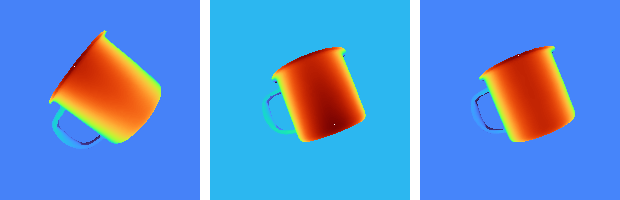

In [78]:
pos = torch.tensor([0.0, 0.0, 2.3],device=device)
quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
pose_gt = posevec_to_matrix_single(pos, quat)
obs_depth, mask_gt = render(pos, quat)
viz_gt = b.get_depth_image(jnp.array(obs_depth[0].cpu().numpy()))
viz_mask_gt = b.get_depth_image(jnp.array(mask_gt[0].cpu().numpy()) * 1.0,max=1.1)
b.viz.hstack_images([viz_gt,viz_mask_gt]).show()

pos = torch.tensor([0.0, 0.0,2.1],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(4,device=device) - 0.5,device=device, requires_grad=True)
rendered_image,_ = render(pos,quat)
viz_orig =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))
pose_optim = posevec_to_matrix_single(pos, quat)

b.show_pose("1", pose_gt.detach().cpu().numpy())
b.show_pose("2", pose_optim.detach().cpu().numpy())

optimizer = torch.optim.SGD([
    {'params': [pos], 'lr': 0.5, "name": "pos"},
    {'params': [quat], 'lr': 0.5, "name": "quat"},
], lr=0.0)
print(quat)
pbar = tqdm(range(200))

for it in pbar:
    rendered_image, _ = render(pos,quat)
    loss = torch.abs((obs_depth - rendered_image) * mask_gt).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{loss.item()}")

pose_optim = posevec_to_matrix_single(pos, quat)
viz =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))

b.clear()
b.show_trimesh("1", m, color=b.BLUE, opacity=0.5)
b.show_trimesh("2", m, color=b.RED, opacity=0.5)
b.set_pose("1", pose_gt.detach().cpu().numpy())
b.set_pose("2", pose_optim.detach().cpu().numpy())
b.hstack_images([viz_orig, viz, viz_gt])

In [29]:
def single_gd(it=20000):
    optimizer = torch.optim.Adam([pos], betas=(0.9, 0.999), lr=1e-5)
    optimizer2 = torch.optim.Adam([quat], betas=(0.9, 0.999), lr=1e-4)
    
    pbar = tqdm(range(it))
    for it in pbar:
        rendered_image, _ = render(pos,quat)
        loss = torch.abs((obs_depth - rendered_image) * mask_gt).mean()
        optimizer.zero_grad()
        optimizer2.zero_grad()

        loss.backward()

        optimizer.step()
        optimizer2.step()

        if it % 200 == 0:
            b.hstack_images([b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy())), viz_gt]).show()

        pbar.set_description(f"{loss.item()}")
    viz =  b.get_depth_image(jnp.array(rendered_image[0].detach().cpu().numpy()))
    b.hstack_images([viz, viz_gt])
    
# single_gd()

## Multi hypo GD

In [35]:
set_seed(0)

Random seed set as 0


/tmp/ipykernel_619/300956869.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)


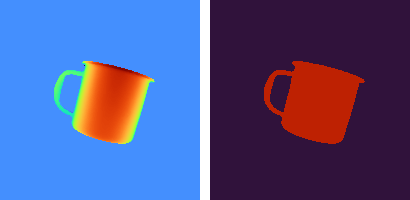

/tmp/ipykernel_619/300956869.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quat =  torch.tensor(torch.rand(num_hypos, 4,device=device) - 0.5,device=device, requires_grad=True)


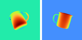

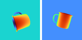

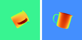

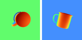

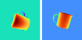

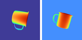

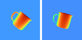

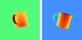

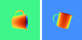

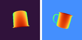

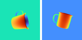

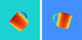

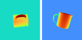

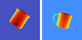

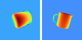

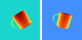

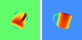

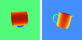

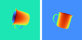

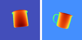

In [36]:
# Ground Truth
pos = torch.tensor([0.0, 0.0, 2.5],device=device)
quat = torch.tensor(torch.rand(4,device=device) - 0.5,device=device)
obs_depth, mask_gt = render(pos, quat)
viz_gt = b.get_depth_image(jnp.array(obs_depth[0].cpu().numpy()))
viz_mask_gt = b.get_depth_image(jnp.array(mask_gt[0].cpu().numpy()) * 1.0,max=1.1)
b.viz.hstack_images([viz_gt,viz_mask_gt]).show()

# Hypotheses
num_hypos = 20
pos = torch.tensor([[0.0, 0.0, 2.4] for _ in range(num_hypos)],device=device, requires_grad=True)
quat =  torch.tensor(torch.rand(num_hypos, 4,device=device) - 0.5,device=device, requires_grad=True)

rendered_images, _ = render_batch(pos,quat)
for rendered_image in rendered_images:
    viz =  b.get_depth_image(jnp.array(rendered_image.detach().cpu().numpy()))
    b.scale_image(b.hstack_images([viz, viz_gt]),0.2).show()

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

new best hypothesis: 6


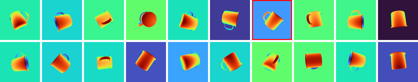

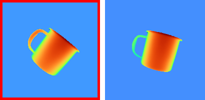

0.3901202082633972:  20%|███████████▋                                               | 198/1000 [00:01<00:05, 146.01it/s]

new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 7


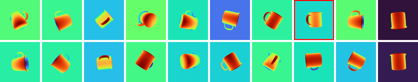

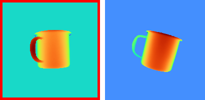

0.38809752464294434:  20%|███████████▍                                              | 198/1000 [00:01<00:05, 146.01it/s]

new best hypothesis: 6
new best hypothesis: 7


0.38384294509887695:  23%|█████████████▏                                            | 228/1000 [00:01<00:06, 125.07it/s]

new best hypothesis: 6
new best hypothesis: 7
new best hypothesis: 6
new best hypothesis: 7


0.35370081663131714:  39%|██████████████████████▊                                   | 393/1000 [00:02<00:04, 145.65it/s]

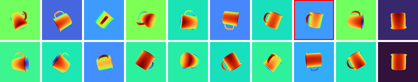

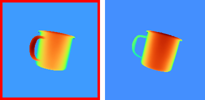

0.3168700635433197:  59%|██████████████████████████████████▋                        | 588/1000 [00:04<00:02, 137.54it/s]

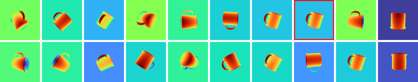

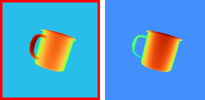

0.3095574378967285:  64%|█████████████████████████████████████▉                     | 644/1000 [00:04<00:02, 126.30it/s]

new best hypothesis: 6


0.2836702764034271:  79%|██████████████████████████████████████████████▎            | 786/1000 [00:05<00:01, 139.60it/s]

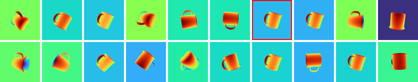

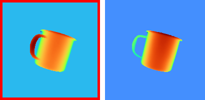

0.2584649324417114: 100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.72it/s]


In [37]:
N = len(pos)
assert N % 2 == 0 or N % 3 == 0 or N % 5 == 0
if N % 5 == 0 and 5 < N//5:
    vh, vw = 5, N//5 
elif N % 3 == 0:
    vh, vw = 3, N//3
else:
    vh, vw = 2, N//2
    
def multi_gd(it=20000):
    prev_min_loss_idx = -1

    pbar = tqdm(range(it))
    optimizer = torch.optim.Adam([pos], betas=(0.9, 0.999), lr=1e-5)
    optimizer2 = torch.optim.Adam([quat], betas=(0.9, 0.999), lr=2e-4)
    for it in pbar:
        rendered_images, _ = render_batch(pos,quat)
        diffs = torch.abs((obs_depth - rendered_images) * mask_gt)

        loss = diffs.mean() * N

        optimizer.zero_grad()
        optimizer2.zero_grad()

        loss.backward()

        optimizer.step()
        optimizer2.step()

        with torch.no_grad():
            img_diffs = torch.mean(diffs * N, dim=(1,2))

            min_loss_val, min_loss_idx = torch.min(img_diffs, 0)

            min_loss_val = float(min_loss_val)
            min_loss_idx = int(min_loss_idx)
            if min_loss_idx != prev_min_loss_idx:
                print(f"new best hypothesis: {min_loss_idx}")
            prev_min_loss_idx = min_loss_idx

        if it % 200 == 0:
            vizs = []
            for i, rendered_image in enumerate(rendered_images):
                viz =  b.get_depth_image(jnp.array(rendered_image.detach().cpu().numpy()))
                if i == min_loss_idx: viz = get_img_with_border(viz, border=5)
                vizs.append(viz)
            b.scale_image(b.hvstack_images(vizs, vh, vw), 0.2).show()  
            b.scale_image(b.hstack_images([vizs[min_loss_idx], viz_gt]), 0.5).show()

        pbar.set_description(f"{loss.item()}")

    best_viz = b.get_depth_image(jnp.array(rendered_images[min_loss_idx].detach().cpu().numpy()))
    b.hstack_images([best_viz, viz_gt])
    
multi_gd(1000)